In [1]:
import os 
import glob
import cv2
import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
from keras.models import Sequential, Model,load_model
from keras.applications.vgg16 import VGG16,preprocess_input
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, Activation
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import Callback, EarlyStopping
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from keras import backend as K
import tensorflow as tf 
import matplotlib.pyplot as plt 

%matplotlib inline 

CHARGEMENT DES DONNEES (IMAGES) :

In [2]:
print(os.listdir("Data"))

['DCM', 'test', 'train', 'valid']


In [3]:
data_dir = Path("Data")
train_dir = data_dir/'train'
valid_dir = data_dir/'valid'
test_dir = data_dir/'test'

In [4]:
def load_train():
    normal_cases_dir = train_dir/'normal'
    adenocarcinoma_cases_dir = train_dir/'adenocarcinoma'

    #Listes des images

    normal_cases = normal_cases_dir.glob('*.png')
    adenocarcinoma_cases = adenocarcinoma_cases_dir.glob('*png')
    train_data = []
    train_label = []

    for img in normal_cases:
        train_data.append(img)
        train_label.append('normal')

    for img in adenocarcinoma_cases:
        train_data.append(img)
        train_label.append('adenocarcinoma')
    
    df = pd.DataFrame(train_data)
    df.columns=['images']
    df['labels']=train_label
    df = df.sample(frac=1).reset_index(drop=True)
    return df

In [5]:
train_data=load_train()
train_data.shape

(331, 2)

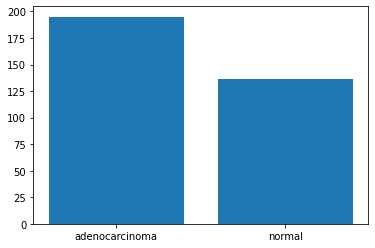

In [6]:
plt.bar(train_data['labels'].value_counts().index, train_data['labels'].value_counts().values)
plt.show()

In [7]:
def plot(image_batch, label_batch):
    plt.figure(figsize=(10,5))
    for i in range(10):
        ax = plt.subplot(2,5,i+1)
        img = cv2.imread(str(image_batch[i]))
        img = cv2.resize(img, (224,224))
        plt.imshow(img)
        plt.title(label_batch[i])
        plt.axis("off")

In [8]:
#plot(image_batch, label_batch)

PRE-PROCESS DES DONNEES :

In [9]:
def prepare_and_load(isval=True):
    if isval==True:
        normal_dir = valid_dir/'normal'
        adenocarcinoma_dir = valid_dir/'adenocarcinoma' 
    else:
        normal_dir = test_dir/'normal'
        adenocarcinoma_dir = test_dir/'adenocarcinoma'
    normal_cases = normal_dir.glob('*.png')
    adenocarcinoma_cases = adenocarcinoma_dir.glob('*.png')
    data, labels = ([] for x in range(2))
    def prepare(case):
        for img in case:
            img = cv2.imread(str(img))
            img = cv2.resize(img, (224, 224))

            if img.shape[2] == 1:
                img = np.dstack([img, img, img])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = img.astype(np.float32)/255.

            if case == normal_cases:
                label = to_categorical(0, num_classes=2)
            else:
                label = to_categorical(1, num_classes=2)
            
            data.append(img)
            labels.append(label)
        return data, labels

    prepare(normal_cases)

    d,l = prepare(adenocarcinoma_cases)
    d = np.array(d)
    l = np.array(l)

    return d,l        

In [10]:
val_data, val_labels = prepare_and_load(isval=True)
test_data, test_labels = prepare_and_load(isval=False)

print('Nombre images test : ', len(test_data))
print('Number images de validation : ', len(val_data))

Nombre images test :  174
Number images de validation :  36


In [11]:
def data_gen(data, batch_size): 
    # nombre total d'échantillons dans les données
    n = len(data)
    steps = n/batch_size

    # création de 2 tableaux pour les groupes de données et labels
    batch_data = np.zeros((batch_size, 224, 224, 3), dtype = np.float32)
    batch_labels = np.zeros((batch_size, 2), dtype = np.float32)

    # un autre tableau pour les indices de données en entrée
    indices = np.arange(n)

    # Initialisation d'un compteur 
    i = 0
    while True: 
        np.random.shuffle(indices)
        # lot suivant
        count = 0
        next_batch = indices[(i*batch_size):(i+1)*batch_size]
        for j, idx in enumerate(next_batch):
            img_name = data.iloc[idx]['images']
            label = data.iloc[idx]['labels']
            if label=='normal':
                label = 0
            else :
                label = 1
            
            encoded_label = to_categorical(label, num_classes=2)

            img = cv2.imread(str(img_name))
            img = cv2.resize(img, (224,224))

            if img.shape[2]==1:
                img = np.dstack([img, img, img])
            
            orig_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            orig_img = img.astype(np.float32)/255

            batch_data[count] = orig_img
            batch_labels[count] = encoded_label

            count+= 1

            if count == batch_size-1:
                break

        i+= 1
        yield batch_data, batch_labels

        if i>=steps:
            i=0 


MODELE DE CLASSIFICATION CNN :

In [12]:
model = Sequential()

model.add(Conv2D(32, (3,3), input_shape = (224, 224, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(32, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(64, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Flatten()) #converti les maps en vecteurs 1D

model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dense(2))
model.add(Activation('softmax'))


batch_size = 16
nb_epochs = 3

# obtenir un générateur de données d'entrainement
train_data_gen = data_gen(data=train_data, batch_size=batch_size)

# défini le nombre d'étapes d'entrainement
nb_train_steps = train_data.shape[0]//batch_size

print("Nombre d'entrainements et d'étapes de validations : {} et {}".format(nb_train_steps, len(val_data)))


Nombre d'entrainements et d'étapes de validations : 20 et 36


In [13]:
model.compile(loss = 'binary_crossentropy',
                optimizer = 'rmsprop',
                metrics =['accuracy'])

# fit le modèle
history = model.fit_generator(train_data_gen, epochs=nb_epochs, steps_per_epoch=nb_train_steps,
                                validation_data=(val_data,val_labels))

C:\Users\thiba\AppData\Local\Temp\ipykernel_19164\1711196156.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_data_gen, epochs=nb_epochs, steps_per_epoch=nb_train_steps,


Epoch 1/3
20/20 [==============================] - 15s 650ms/step - loss: 0.8251 - accuracy: 0.7125 - val_loss: 0.3957 - val_accuracy: 0.8611
Epoch 2/3
20/20 [==============================] - 12s 589ms/step - loss: 0.2801 - accuracy: 0.8813 - val_loss: 0.1930 - val_accuracy: 0.9444
Epoch 3/3
20/20 [==============================] - 12s 597ms/step - loss: 0.0832 - accuracy: 0.9625 - val_loss: 0.0871 - val_accuracy: 1.0000


TRANSFERT D'APPRENTISSAGE :

In [14]:
def vgg16_model(num_classes=None): 

    model = VGG16(weights='imagenet', include_top=True, input_shape=(224, 224, 3))

    x = Dense(1024, activation='relu')(model.layers[-4].output)
    x = Dropout(0.7)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(2, activation='softmax')(x)

    model = Model(model.input,x)

    return model

In [15]:
vgg_conv = vgg16_model(2)

for layer in vgg_conv.layers[:-10]: # freeze tous les layers sauf les 10 derniers
    layer.trainable = False

In [16]:
opt = Adam(lr=0.0001, decay=1e-5)
vgg_conv.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=opt)

# on fit le modèle
history = vgg_conv.fit_generator(train_data_gen, epochs=nb_epochs, steps_per_epoch=nb_train_steps,
                                    validation_data=(val_data,val_labels),
                                    class_weight={0:1.0, 1:0.4})

c:\Users\thiba\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
C:\Users\thiba\AppData\Local\Temp\ipykernel_19164\3137498313.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = vgg_conv.fit_generator(train_data_gen, epochs=nb_epochs, steps_per_epoch=nb_train_steps,


Epoch 1/3
20/20 [==============================] - 104s 5s/step - loss: 0.4105 - accuracy: 0.6812 - val_loss: 0.2319 - val_accuracy: 0.9722
Epoch 2/3
20/20 [==============================] - 104s 5s/step - loss: 0.1246 - accuracy: 0.8844 - val_loss: 0.0260 - val_accuracy: 1.0000
Epoch 3/3
20/20 [==============================] - 99s 5s/step - loss: 0.0511 - accuracy: 0.9375 - val_loss: 0.0464 - val_accuracy: 0.9722


In [17]:
loss , acc = vgg_conv.evaluate(test_data, test_labels, batch_size = 16)
print('Perte et Précision : ',loss,'&',acc)

11/11 [==============================] - 39s 3s/step - loss: 0.0861 - accuracy: 0.9655
Perte et Précision :  0.08609364181756973 & 0.9655172228813171


EVALUATION DES PERFORMANCES DU MODELE :

In [18]:
# predictions 
pred = vgg_conv.predict(test_data, batch_size=16)
pred = np.argmax(pred, axis=-1)

#label original
labels = np.argmax(test_labels, axis=-1)

from sklearn.metrics import classification_report

print(classification_report(labels, pred))

11/11 [==============================] - 36s 3s/step
              precision    recall  f1-score   support

           0       0.91      0.98      0.95        54
           1       0.99      0.96      0.97       120

    accuracy                           0.97       174
   macro avg       0.95      0.97      0.96       174
weighted avg       0.97      0.97      0.97       174



<AxesSubplot:>

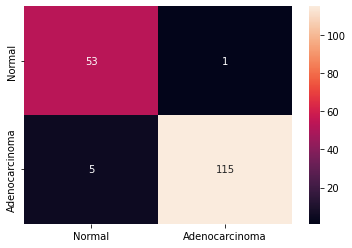

In [19]:
# matrice de confusion
cm = confusion_matrix(labels, pred)

import seaborn as sns

sns.heatmap(cm, annot=True, fmt='g', xticklabels=['Normal', 'Adenocarcinoma'], yticklabels=['Normal', 'Adenocarcinoma'])